# Validation of the PyPSA-Africa Installed capacity

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [1]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

### Set main directory to root folder

In [2]:
# set current folders
import sys

sys.path.append("../../")  # adds path to $ .../pypsa-africa
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")  # moves path to root

This is the repository path:  /mnt/c/Users/scl38887/Documents/git/pypsa-africa
Had to go 2 folder(s) up.


## 1. Load data 

#### IRENA data
Retrieved from [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).\
Please, download the statistics for 2020 for all the world and specify the url specified above.

In [14]:
from scripts._helpers import country_name_2_two_digits  # _helpers are from pypsa

year_select = 2020

IRENA_path = "ELECCAP_20220726-071742.csv"
df_irena = pd.read_csv(IRENA_path, skiprows=2, encoding="latin-1")
df_irena = df_irena[df_irena.loc[:, "Year"] == year_select]
df_irena = df_irena.iloc[:, [0, 1, 2, 4]]
# df = df[df["iso_code"].notna()]  # removes antartica
df_irena["alpha2"] = df_irena.loc[:, "Country/area"].apply(
    lambda x: country_name_2_two_digits(x)
)
# electricity_demand_owid = df
# electricity_demand_owid.tail(2)

,Country/area,Technology,Grid connection,Installed electricity capacity by country/area (MW),alpha2
0,Afghanistan,Solar photovoltaic,On-grid,11.700,AF
1,Afghanistan,Solar photovoltaic,Off-grid,19.045,AF
2,Afghanistan,Solar thermal energy,On-grid,..,AF
3,Afghanistan,Solar thermal energy,Off-grid,..,AF
4,Afghanistan,Onshore wind energy,On-grid,0.300,AF


#### PyPSA generator data

Loads the PyPSA generators data

##### Load data from the network and create normalized dataframe

In [51]:
solved_network_path = os.getcwd() + "/networks/elec_s_55_ec_lcopt_Co2L-3H.nc"
pypsa_network = pypsa.Network(solved_network_path)

# statistics of non-storage units
installed_capacity_nostorages = pypsa_network.generators.copy()

# delete load if it appears in network
installed_capacity_nostorages.drop(
    installed_capacity_nostorages[
        installed_capacity_nostorages["carrier"] == "load"
    ].index,
    inplace=True,
)

installed_capacity_nostorages.loc[:, "alpha2"] = (
    installed_capacity_nostorages.index.to_series().apply(lambda x: x[0:2]).values
)
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "ror", "carrier"
] = "hydro"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "CCGT", "carrier"
] = "gas"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "OCGT", "carrier"
] = "gas"
installed_capacity_nostorages_select = installed_capacity_nostorages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]

# statistics of storage units
installed_capacity_storages = pypsa_network.storage_units.copy()
installed_capacity_storages.loc[:, "alpha2"] = (
    installed_capacity_storages.index.to_series().apply(lambda x: x[0:2]).values
)
installed_capacity_storages.loc[
    installed_capacity_storages["carrier"] == "PHS", "carrier"
] = "hydro"
installed_capacity_storages_select = installed_capacity_storages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]


installed_capacity_raw = pd.concat(
    [installed_capacity_storages_select, installed_capacity_nostorages_select]
)
installed_capacity = installed_capacity_raw.groupby(["alpha2", "carrier"])[
    "p_nom"
].sum()
installed_capacity.groupby("carrier").sum()

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 0], imported network file PyPSA version [0, 19, 3].

INFO:pypsa.io:Imported network elec_s_55_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier
coal      40525.363358
gas       35202.323744
hydro     30090.654591
oil       49642.170076
onwind     6376.302032
solar      9150.483426
Name: p_nom, dtype: float64

##### Load PyPSA powerplant data to crosscheck data from the network

In [52]:
powerplants_data = os.getcwd() + "/resources/powerplants.csv"
available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])[
    "Capacity"
].sum()
installed_capacity_resources.groupby(["Fueltype"]).sum()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/scl38887/Documents/git/pypsa-africa/resources/powerplants.csv'

# 2. Validate

#### Steps:
- Specify year of interest of the IRENA dataset and the countries of interest
- Harmonize IRENA dataset to the PyPSA standard
- Align dataframe naming and temporal resolution
- Merge dataframe


##### Specify year of the analysis and the countries of interest

In [53]:
year_owid = 2020  # option
country_list = installed_capacity_nostorages.alpha2.unique()
country_list

array(['AO', 'BI', 'BJ', 'BW', 'CD', 'CF', 'CG', 'CI', 'CM', 'DZ', 'EG',
       'EH', 'ER', 'ET', 'GA', 'GH', 'GM', 'GN', 'GQ', 'GW', 'KE', 'LR',
       'LS', 'LY', 'MA', 'MG', 'ML', 'MR', 'MW', 'MZ', 'NA', 'NE', 'NG',
       'RW', 'SD', 'SL', 'SN', 'SO', 'SS', 'SZ', 'TD', 'TG', 'TN', 'TZ',
       'UG', 'ZA', 'ZM', 'ZW'], dtype=object)

##### Process IRENA data to match PyPSA standard

In [55]:
# copy IRENA dataset
df = df_irena.copy()

# Process technologies
df.loc[
    df["Technology"].isin(["Solar photovoltaic", "Solar thermal energy"]), "Technology"
] = "solar"
df.loc[
    df["Technology"].isin(["Onshore wind energy", "Offshore wind energy"]), "Technology"
] = "wind"
df.loc[
    df["Technology"].isin(
        ["Renewable hydropower", "Mixed Hydro Plants", "Pumped storage"]
    ),
    "Technology",
] = "hydro"
df.loc[
    df["Technology"].isin(["Other non-renewable energy", "Marine energy"]), "Technology"
] = "Other"
df.loc[
    df["Technology"].isin(["Liquid biofuels", "Biogas", "Solid biofuels"]), "Technology"
] = "Bioenergy"
df.loc[df["Technology"].isin(["Geothermal energy"]), "Technology"] = "Geothermal"
df.loc[df["Technology"].isin(["Natural gas"]), "Technology"] = "gas"
df.loc[df["Technology"].isin(["Renewable municipal waste"]), "Technology"] = "waste"
df.loc[df["Technology"].isin(["Coal and peat"]), "Technology"] = "coal"
df.loc[df["Technology"].isin(["Oil", "Fossil fuels n.e.s."]), "Technology"] = "oil"


df = df[df.alpha2.isin(country_list)]
df["p_nom"] = pd.to_numeric(
    df["Installed electricity capacity by country/area (MW)"], errors="coerce"
)
installed_capacity_irena = (
    df.rename(columns={"Technology": "carrier"})
    .groupby(["alpha2", "carrier"])["p_nom"]
    .sum()
)
installed_capacity_irena.groupby("carrier").sum()

carrier
Bioenergy       1462.517
Geothermal       870.300
Nuclear         1940.000
Other            100.000
coal           47471.600
gas           100760.933
hydro          33376.493
oil            26367.624
solar          10364.006
waste             25.000
wind            6421.323
Name: p_nom, dtype: float64

##### Merge datasets by carrier

<AxesSubplot:xlabel='Technology', ylabel='Capacity [GW]'>

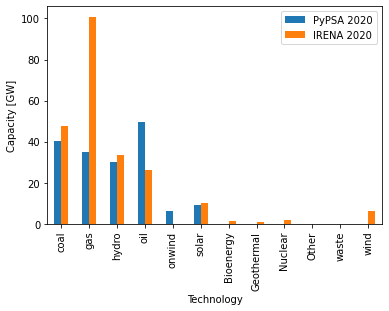

In [56]:
world_ic = installed_capacity_irena.groupby("carrier").sum() / 1000
world_pypsa = installed_capacity.groupby("carrier").sum() / 1000
world_compare = pd.concat(
    [world_pypsa.rename("PyPSA 2020"), world_ic.rename("IRENA 2020")], axis=1
)
world_compare.plot.bar(ylabel="Capacity [GW]", xlabel="Technology")

<AxesSubplot:xlabel='Technology', ylabel='Capacity [GW]'>

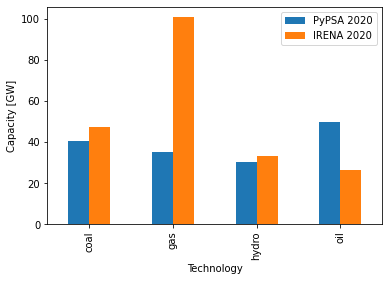

In [57]:
list_carriers = ["coal", "gas", "hydro", "oil"]

world_compare[world_compare.index.isin(list_carriers)].plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology"
)

##### Merge dataframes by technology for specific country

According to [USAID](https://www.usaid.gov/powerafrica/nigeria), the total installed generation in Nigeria is:
- Hydro: 2.062 GW
- Gas: 11.972 GW
- Wind: 0.01 GW
- Solar: 0.007 GW
- Other/Diesel/HFO: 2.333 GW

Total: 16.384 GW

Power Africa new MW to date at financial close: 3.043 GW

In [146]:
# Get data from usaid manually
usaid_ng = pd.DataFrame(
    data=[2.062, 11.972, 0.01, 0.007, 2.333],
    index=["Hydro", "Gas", "Wind", "Solar", "Other/Diesel/HFO"],
    columns=["USAID (year?)"],
)

# Prepare data from usaid
usaid_ng.index.name = "carrier"

usaid_ng.rename(
    index={
        "Hydro": "hydro",
        "Gas": "gas",
        "Wind": "wind",
        "Solar": "solar",
        "Other/Diesel/HFO": "oil",
    },
    inplace=True,
)
print("WARNING: Other/Diesel/HFO is renamed to 'Oil'")

In [147]:
usaid_ng.head()

,USAID (year?)
carrier,
hydro,2.062
gas,11.972
wind,0.010
solar,0.007
oil,2.333


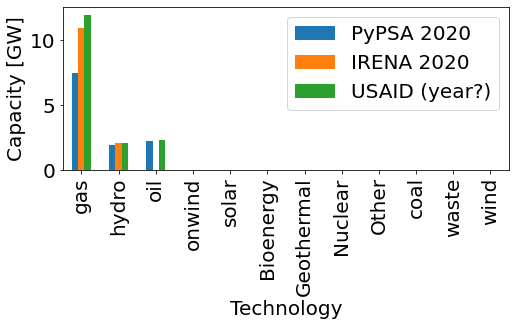

In [164]:
country = "NG"
country_ic = (
    installed_capacity_irena.iloc[
        installed_capacity_irena.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_pypsa = (
    installed_capacity.iloc[
        installed_capacity.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = country_compare.index.get_level_values(1)
country_compare = pd.concat([country_compare, usaid_ng], axis=1)
ax = country_compare.plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(8, 3)
)
# optional:save it
# ax.figure.savefig("capacitiy-validation-ng.pdf", bbox_inches='tight')

##### Merge dataframes by country

<AxesSubplot:xlabel='Country', ylabel='Capacity [GW]'>

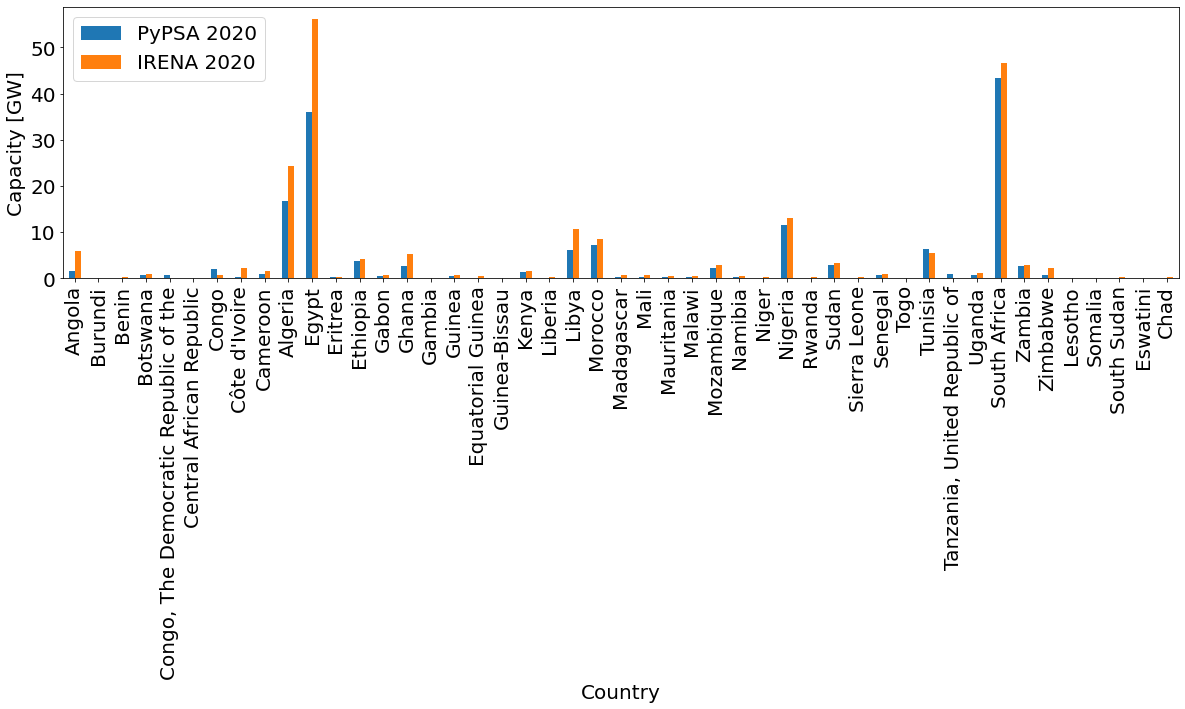

In [58]:
from scripts._helpers import two_digits_2_name_country

country_ic = (
    installed_capacity_irena[
        installed_capacity_irena.index.get_level_values(1).isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)
country_pypsa = (
    installed_capacity[installed_capacity.index.get_level_values(1).isin(list_carriers)]
    .groupby("alpha2")
    .sum()
    / 1000
)

country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = country_compare.index.map(two_digits_2_name_country)
plt.rcParams.update({"font.size": 20})
country_compare.plot.bar(
    figsize=(20, 5), ylabel="Capacity [GW]", xlabel="Country", fontsize=20
)